# Working with multiple domains 1: Simple cohort comparision

In spatial biology, analyses rarely involve a single spatial region in isolation. More commonly, we work with multiple spatial domains: replicate samples from the same biological source, samples drawn from distinct cohorts, control versus treatment conditions, comparisons across mouse lines, or different cancer types. In these settings, the objective is not merely to compute spatial metrics for individual samples, but to do so at scale—and, critically, to compare those measurements across many spatially distinct regions.

This tutorial series focuses on strategies for analysing and comparing multiple spatial samples using MuSpAn. While this may seem straightforward at first glance, cohort-level spatial analysis is a non-trivial problem. The appropriate way to aggregate or compare spatial metrics across domains depends on the metric itself and on properties of each spatial region. Assumptions underlying a given statistic may not propagate cleanly across heterogeneous domains, and naïve aggregation can lead to misleading results. For this reason, subsequent tutorials will concentrate on specific spatial metrics and discuss principled approaches to aggregating and comparing them across samples.

Before addressing the technical details of individual metrics, such as the pair correlation function (PCF) or quadrat count-based measures (QCM), this introductory tutorial demonstrates how to set up a high-throughput cohort analysis workflow in MuSpAn. We will load multiple spatial domains, assign them to experimental groups, compute summary properties, and perform basic comparisons. 

---

### Focus of this tutorial 

The emphasis here is on the underlying infrastructure: how MuSpAn leverages native Python data structures and idioms to enable scalable, flexible analysis of many spatial domains simultaneously 

Note that there are different ways to handle mutliple domains for analysis - this tutorial is just one example!

---

## A cohort dataset

To In this tutorial series, we’ll be working with data from **Schürch  (Cell, 2020)** https://www.sciencedirect.com/science/article/pii/S0092867420308709#abs0020 —  
*“Coordinated cellular neighborhoods orchestrate antitumoral immunity at the colorectal cancer invasive front.”*  

This dataset was generated using **CODEX (CO-Detection by Indexing)**, a highly multiplexed imaging technology that enables spatially resolved, single-cell profiling of many protein markers within intact tissue sections.

---

#### 🧫 Data summary
- **35 patients** with colorectal cancer  
- **140 tissue microarray (TMA) cores**, sampled from regions near the **invasive front** of each tumour  
- Each row in the dataset corresponds to a **single cell**, annotated with:
  - **Spatial coordinates (X, Y)**
  - **Cell type** (from multiplexed immunofluorescence clustering)
  - **TMA core / domain ID**
  - **Patient group information**

---

#### 🧠 Biological context
The study identified two key immune microenvironment patterns:
- **Crohn’s-like reaction (CLR)** — characterised by organised immune cell aggregates and a coordinated anti-tumour response.  
- **Diffuse inflammatory infiltration (DII)** — showing a more scattered, less coordinated immune cell presence.  

Patients exhibiting **CLR** have **significantly better overall survival** compared to those with **DII**.

---

#### 📊 Data Information
- Each row represents a **single cell**.  
- **`spots`** – unique ID for each TMA.  
- **`groups`** – patient group ID (`1` for CLR or `2` for DII).  
- **`ClusterName`** – cell type, as determined by clustering of immunofluorescence per cell.  
- **`X:X`** – x-coordinate of the cell.  
- **`Y:Y`** – y-coordinate of the cell.  

---

We’re providing the **full dataset** for this analysis so you can **identify and extract only the relevant information** required to address our questions.


#### Starting simple: comparing cell densities across cohorts

To get a hang of handling multiple domains, we start simple by just comparing cell type densities in the TMAs across patient groups. For this we'll need to:

1. **Load the TMA data** into a DataFrame.  
2. **Create domains** for each TMA — be sure to include a way to identify groups (for example, using the domain name).  
3. **Compute cell type densities** across all samples and collate information for each group
4. **Compare groups** in terms of cell type density, computing statistical tests for identifying significant differences between groups and visualise results to summarise our cohort analysis.

This notebook tutorial will be structured using these steps.

--- 

### 1. Load the TMA data

Don't worry about finding any data, everything we need is stored online. The following cell gets all required imports and loads in a csv file wiht the cohort data. 

In [1]:
import muspan as ms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import mannwhitneyu


# Load the Nolan et al. (2020) TMA dataset from the provided URL
nolan_tma_dataframe = pd.read_csv("https://docs.muspan.co.uk/workshops/data_for_workshops/Nolan_2020_data%201.csv")

# Display the first few rows of the dataframe
nolan_tma_dataframe.head()

,Unnamed: 0,CellID,ClusterID,EventID,File Name,Region,TMA_AB,TMA_12,Index in File,groups,...,CD68+Ki67+,CD68+PD-1+,CD8+ICOS+,CD8+Ki67+,CD8+PD-1+,Treg-ICOS+,Treg-Ki67+,Treg-PD-1+,neighborhood number final,neighborhood name
0,0,0,10668,0,reg001_A,reg001,A,1,0,1,...,0,0,0,0,0,0,0,0,9.0,Granulocyte enriched
1,1,1,10668,4,reg001_A,reg001,A,1,4,1,...,0,0,0,0,0,0,0,0,4.0,Macrophage enriched
2,2,2,10668,5,reg001_A,reg001,A,1,5,1,...,0,0,0,0,0,0,0,0,3.0,Immune-infiltrated stroma
3,3,3,10668,6,reg001_A,reg001,A,1,6,1,...,0,0,0,0,0,0,0,0,3.0,Immune-infiltrated stroma
4,4,4,10668,30,reg001_A,reg001,A,1,30,1,...,0,0,0,0,0,0,0,0,4.0,Macrophage enriched


We’re providing the **full dataset** in this csv file, so we can **identify and extract only the relevant information** required to address our questions below

### 2. Create domains

Now we have all the cohort data loaded in, let's generate domains for each sample using the necessary data. We'll name each sample by it's TMA ID and patient group ID. This will allow us to identify the domains that match the the respective patient groups 


In [2]:

# Get unique spot IDs
spot_IDs=np.unique(nolan_tma_dataframe['spots'])

# Initialise an empty list to hold domain objects
list_of_domains = []

# Create a color map for cell types to be consistent across domains
unique_cell_types = nolan_tma_dataframe['ClusterName'].unique() 
cell_colors = [sns.color_palette('tab20')[i % 20] for i in range(len(unique_cell_types))]
cmap_dict = {unique_cell_types[v]: cell_colors[v] for v in range(len(unique_cell_types))}

# loop over each unique spot ID to create domain objects
for spot in spot_IDs:
    
    # Create a mask to filter the dataframe for the current spot
    mask = nolan_tma_dataframe['spots']==spot
    
    # get the points and labels for the current spot
    points = nolan_tma_dataframe[mask][['X:X','Y:Y']]
    labels = nolan_tma_dataframe[mask]['ClusterName']
    this_group = nolan_tma_dataframe[mask]['groups'].values[0]   
    this_name=str(spot)+'_group_'+str(this_group)
    
    # Create a domain object for the current spot
    this_domain = ms.domain(this_name)
    
    # Add points and labels to the domain object
    this_domain.add_points(points.values,'cells')
    
    # Add cell type labels to the domain object
    this_domain.add_labels('cell type',labels.values)
    
    # Estimate the convex hull boundary for the domain
    this_domain.estimate_boundary('convex hull')
    
    # Set the color map for cell types
    this_domain.update_colors(cmap_dict,label_name='cell type')
    
    # Append the domain object to the list
    list_of_domains.append(this_domain)
    

Let's just check what these domains look like before we run any analysis to make sure we've imported correctly:

In [3]:
group_id = np.array([domain.name[-1] for domain in list_of_domains])
group_1_indices = np.where(group_id=='1')[0]
group_2_indices = np.where(group_id=='2')[0]

print(f'Number of group 1 domains: {len(group_1_indices)}')
print(f'Number of group 2 domains: {len(group_2_indices)}')

Number of group 1 domains: 68
Number of group 2 domains: 72


We'll just visualise the domains from patient group 1 first:

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

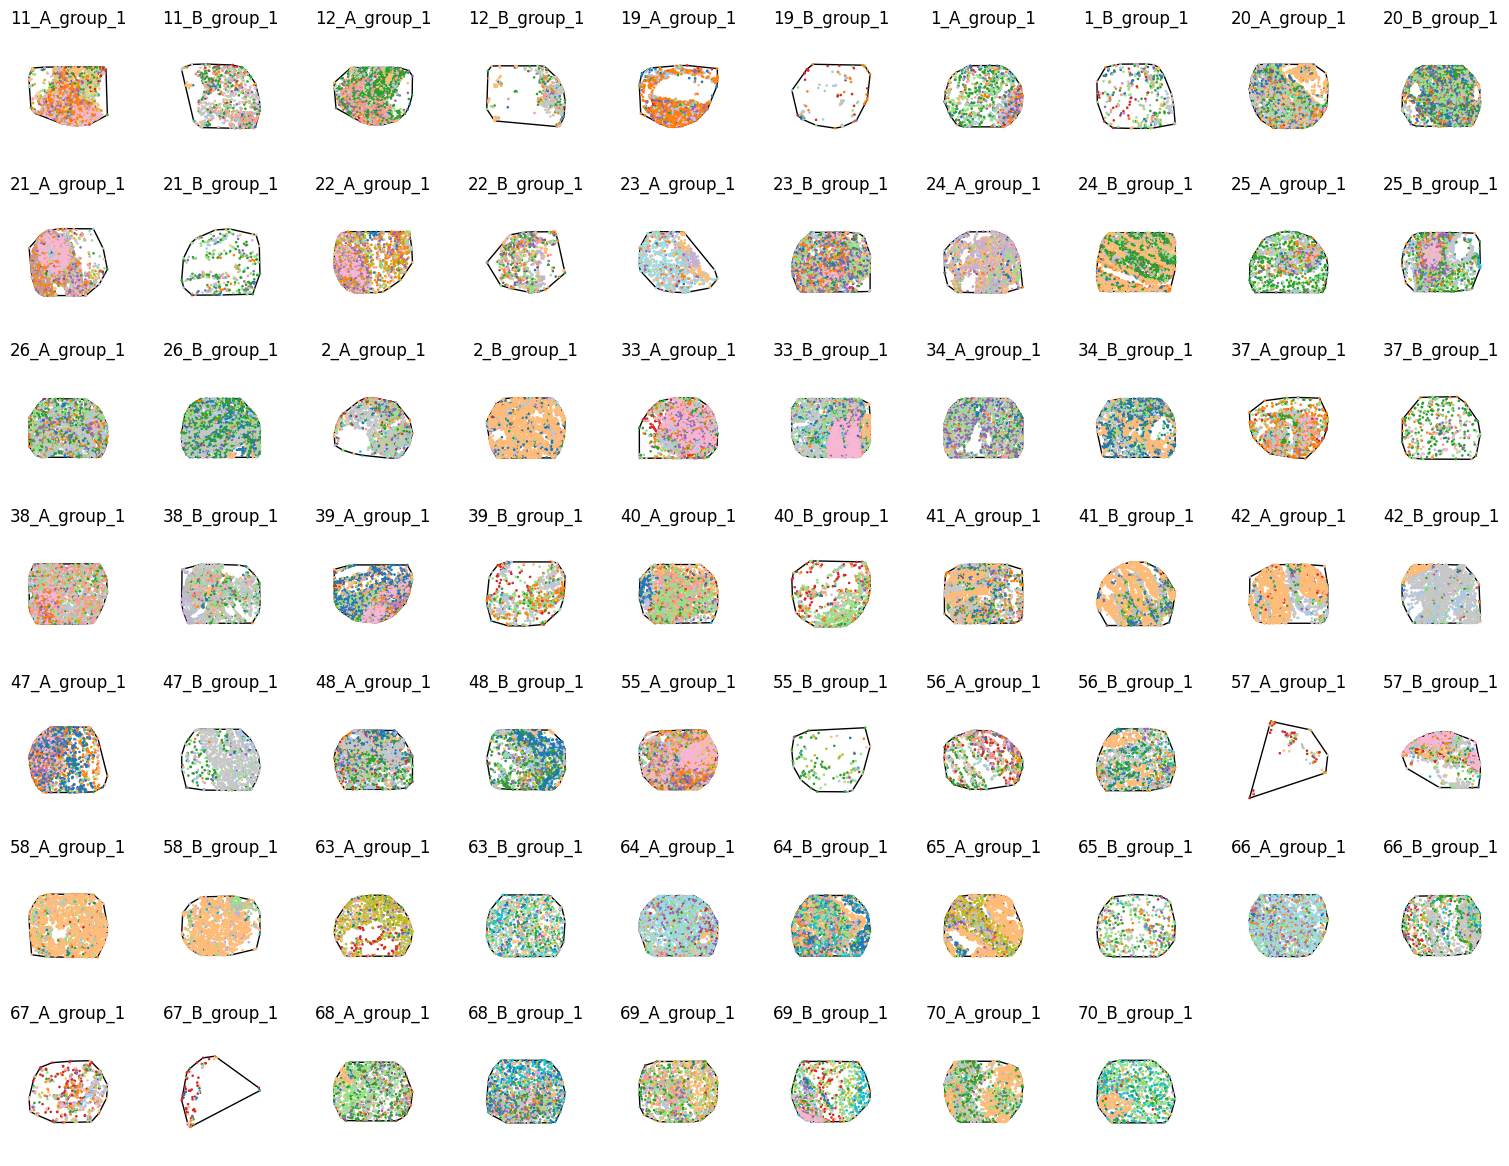

In [4]:
# Visualise all group 1 domains in a grid layout
fig,axes = plt.subplots(7,10, figsize=(15,12),constrained_layout=True)
for i, id in enumerate(group_1_indices):
    # Get the current axis
    this_ax = axes.flatten()[i]
    
    # Get the current domain
    this_domain = list_of_domains[id]
    
    # Visualise the domain
    ms.visualise.visualise(this_domain,
                            color_by='cell type',
                            marker_size=0.75,
                            show_boundary=True,
                            boundary_kwargs=dict(linewidth=1,edgecolor='black',facecolor='none'),
                            add_cbar=False,
                            ax=this_ax)
    
    # Set the title of the subplot
    this_ax.set_title(this_domain.name)
    axes.flatten()[i].axis('off')

# Turn off any unused subplots   
axes.flatten()[-1].axis('off')      
axes.flatten()[-2].axis('off')


Now group 2:

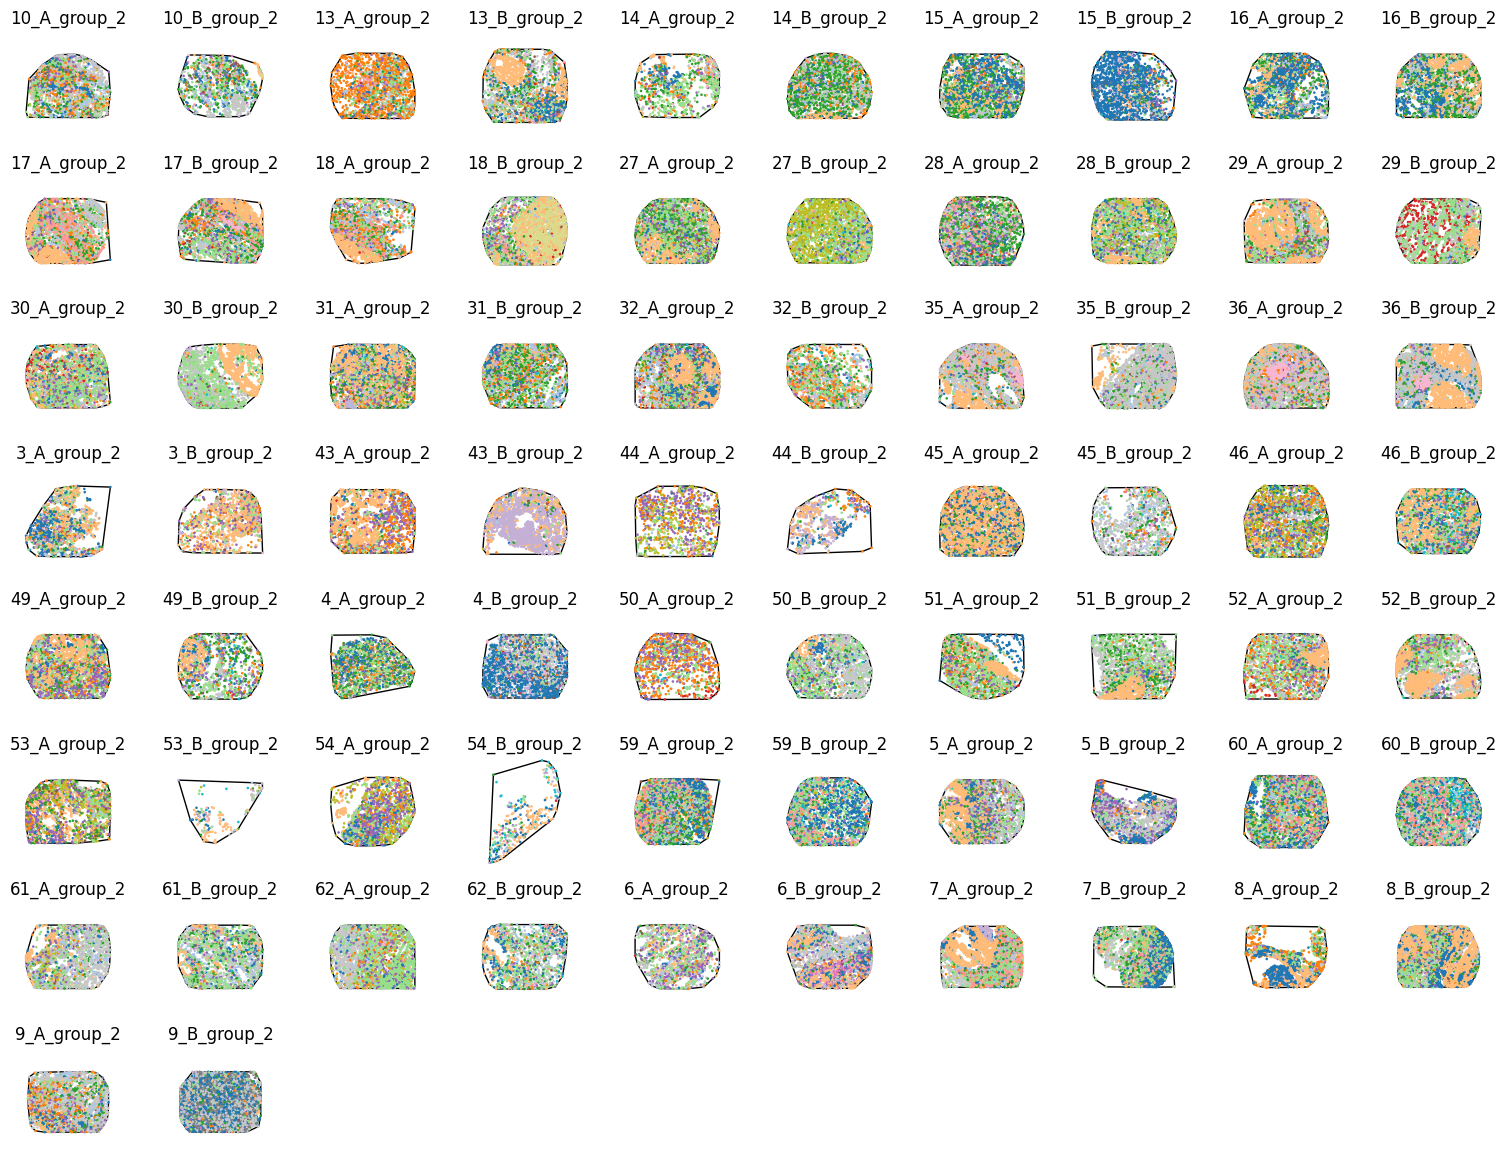

In [5]:
# Visualise group 2 domains
fig,axes = plt.subplots(8,10, figsize=(15,12),constrained_layout=True)

# Loop over group 2 indices and plot each domain
for i, id in enumerate(group_2_indices):
    # Get the current axis
    this_ax = axes.flatten()[i]
    
    # Get the current domain
    this_domain = list_of_domains[id]
    
    # Visualise the domain
    ms.visualise.visualise(this_domain,
                            color_by='cell type',
                            marker_size=0.75,
                            show_boundary=True,
                            boundary_kwargs=dict(linewidth=1,edgecolor='black',facecolor='none'),
                            add_cbar=False,
                            ax=this_ax)
    
    # Set the title of the subplot
    this_ax.set_title(this_domain.name)
    axes.flatten()[i].axis('off')

# Turn off any unused subplots
for i in range(9):    
    axes.flatten()[-i].axis('off')      


These domains all look consistent with the data published by Schürch et al. (2020) therefore let's go ahead with some analysis.

### 3. Compute cell type densities

With all our domains now stored within a python list, we can loop through this to compute our densities. We need to be careful we are keeping our data consistent across samples, namely the ordering of density computations which may change if a cell type is not present in any given sample, so we need a global reference for ordering. 

In [6]:
densities_of_celltype_group_1=[]
densities_of_celltype_group_2=[]

# get unique cluster categories - this will define the order of cell type densities across the samples
unique_labels = nolan_tma_dataframe['ClusterName'].unique() 

# loop through the domains
for domain in list_of_domains:
    # compute the density of the cell types
    sample_density,_,sample_label_categories = ms.summary_statistics.label_density(domain,label_name='cell type')
    
    # initialise an array to collect densities for this domain
    these_densities = np.zeros(len(unique_labels))
    
    # for each label category, populate the corresponding density ordered by unique_labels
    for i, lab in enumerate(sample_label_categories):
        these_densities[np.where(unique_labels==lab)[0][0]] = sample_density[i]
    
    # append to the appropriate group list
    if domain.name.endswith('_group_1'):
        densities_of_celltype_group_1.append(these_densities)
    elif domain.name.endswith('_group_2'):
        densities_of_celltype_group_2.append(these_densities)
 
# convert lists to numpy arrays - rows are samples, columns are cell type densities      
densities_of_celltype_group_1 = np.vstack(densities_of_celltype_group_1)
densities_of_celltype_group_2 = np.vstack(densities_of_celltype_group_2)

# combine all densities and create group indicator array
all_neigh_densities = np.vstack([densities_of_celltype_group_1,densities_of_celltype_group_2])    
group_indicator = np.array([1]*densities_of_celltype_group_1.shape[0]+[2]*densities_of_celltype_group_2.shape[0])

### 4. Compare groups

Following the computation of the densities across all domains and globally aligning our results, we can now easily compare between the patient groups. For this, we will test the difference in density distributions between the patient groups using a Mann-Whitney U test. To start, let's just compare the density of our tumour cells.

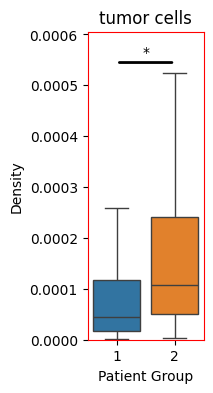

In [7]:
# compare densities for B cells
alpha_level = 0.05
cell_type_of_interest = 'tumor cells'   
cell_type_index = np.where(unique_labels==cell_type_of_interest)[0][0]

# create boxplot comparing the two groups for the current cluster
fig,ax=plt.subplots(figsize=(1.5,4))
sns.boxplot(x=group_indicator,y=all_neigh_densities[:,cell_type_index],hue=group_indicator,palette='tab10',showfliers=False,ax=ax)

# clean up the boxplot
ymax = ax.get_ylim()[1]
ax.set_ylim(0, ymax*1.1)
ax.set_xlabel('Patient Group')
ax.set_ylabel(f'Density')
ax.legend_.remove()
ax.set_title(f'{cell_type_of_interest}')  

# Perform Mann-Whitney U test between the two groups for the current cluster
group_1_data = all_neigh_densities[group_indicator == 1, cell_type_index]
group_2_data = all_neigh_densities[group_indicator == 2, cell_type_index]
stat, p_value = mannwhitneyu(group_1_data, group_2_data)

# add significance annotation if p-value is below alpha level and set axis color to red
if p_value < alpha_level:
    # color the axis red
    for spine in ax.spines.values():
        spine.set_edgecolor('red')
        
    # add significance annotation
    ax.annotate('', xy=(0.25, 0.9), xycoords='axes fraction', xytext=(0.75, 0.9),
                textcoords='axes fraction', arrowprops=dict(arrowstyle='-', color='k', lw=2))
    ax.text(0.5, 0.91, f'*', ha='center', va='bottom', transform=ax.transAxes, color='k')



So we see an significant increase in the density of tumour cells within the patient group 2 (Diffuse inflammatory infiltration classified group). Let's do the same from all our cell types and isolate those that have significantly changed.

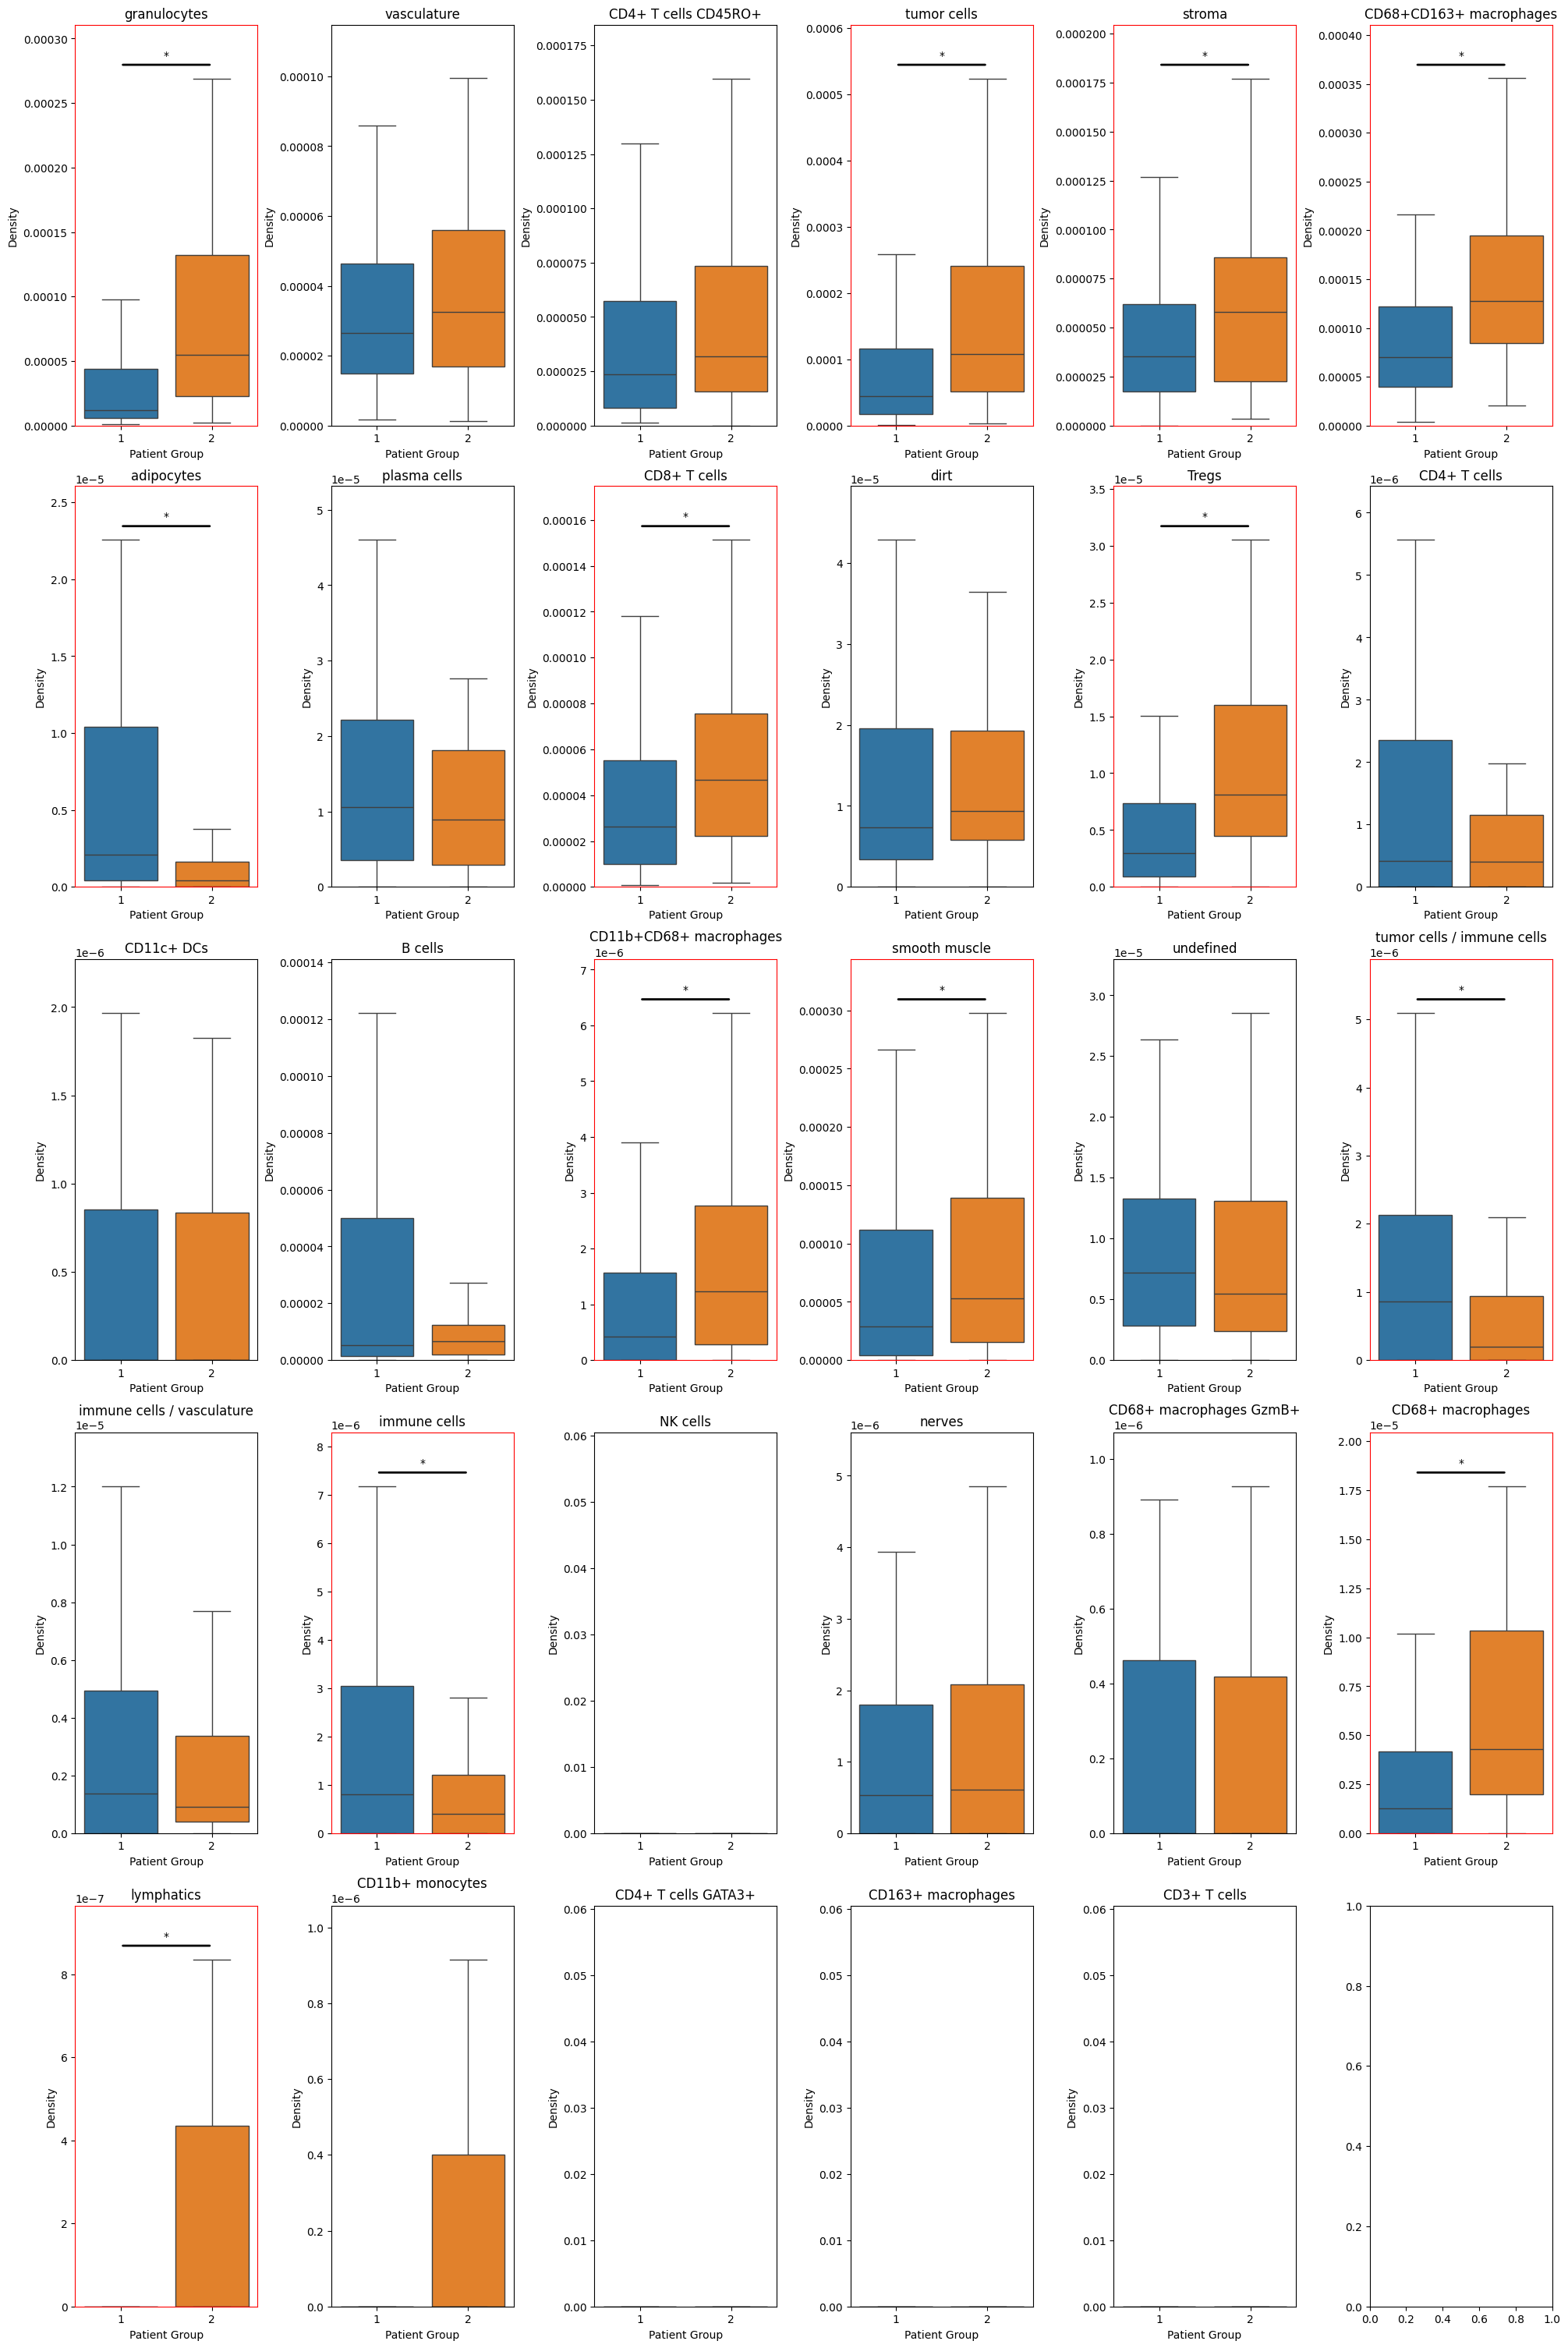

In [8]:
# list to hold significant cell types
sig_density_cell_types = []

# create a figure with subplots for each cell type
fig,axes=plt.subplots(nrows=5,ncols=6,figsize=(20,30),constrained_layout=True)

for i,cell_type_of_interest in enumerate(unique_labels):
    
    cell_type_index = np.where(unique_labels==cell_type_of_interest)[0][0]
    this_ax = axes.flatten()[i] 

    # create boxplot comparing the two groups for the current cluster
    sns.boxplot(x=group_indicator,y=all_neigh_densities[:,cell_type_index],hue=group_indicator,palette='tab10',showfliers=False,ax=this_ax)

    # clean up the boxplot
    ymax = this_ax.get_ylim()[1]
    this_ax.set_ylim(0, ymax*1.1)
    this_ax.set_xlabel('Patient Group')
    this_ax.set_ylabel(f'Density')   
    this_ax.legend_.remove()
    this_ax.set_title(f'{cell_type_of_interest}')  

    # Perform Mann-Whitney U test between the two groups for the current cluster
    group_1_data = all_neigh_densities[group_indicator == 1, cell_type_index]
    group_2_data = all_neigh_densities[group_indicator == 2, cell_type_index]
    stat, p_value = mannwhitneyu(group_1_data, group_2_data)

    # add significance annotation if p-value is below alpha level and set axis color to red
    if p_value < alpha_level:
        # append to significant list
        sig_density_cell_types.append(cell_type_of_interest)
        
        # color the axis red
        for spine in this_ax.spines.values():
            spine.set_edgecolor('red')
            
        # add significance annotation
        this_ax.annotate('', xy=(0.25, 0.9), xycoords='axes fraction', xytext=(0.75, 0.9),
                    textcoords='axes fraction', arrowprops=dict(arrowstyle='-', color='k', lw=2))
        this_ax.text(0.5, 0.91, f'*', ha='center', va='bottom', transform=this_ax.transAxes, color='k')

And we can print out the significantly changing distributions below:

In [9]:
print("Cell types with significant differences in density between patient groups:", sig_density_cell_types)

Cell types with significant differences in density between patient groups: ['granulocytes', 'tumor cells', 'stroma', 'CD68+CD163+ macrophages', 'adipocytes', 'CD8+ T cells', 'Tregs', 'CD11b+CD68+ macrophages', 'smooth muscle', 'tumor cells / immune cells', 'immune cells', 'CD68+ macrophages', 'lymphatics']


### Summary

In this tutorial, we demonstrated how MuSpAn can be used to carry out a simple but representative cohort-level spatial analysis. By comparing cell type densities across TMAs from different patient groups, we illustrated how multiple spatial domains can be loaded, organised, and analysed together within a single, coherent workflow.
The emphasis throughout was not on the complexity of the spatial metric itself, but on the structure of the analysis: how domains are constructed, how group-level metadata is propagated, and how results from individual samples can be collated, compared, and summarised. These steps form the foundation of any high-throughput spatial analysis, regardless of the specific statistic being computed.

Importantly, this workflow highlights how MuSpAn leverages native Python concepts to scale naturally from single-sample analyses to cohort-level studies. Once this structure is in place, more sophisticated spatial metrics—such as those capturing spatial interaction or higher-order organisation—can be applied using the same underlying patterns.
In subsequent tutorials, we will build on this framework to explore more complex spatial statistics and discuss the additional considerations required when aggregating and comparing these metrics across heterogeneous spatial domains.